In [1]:
#IMPORT PACKAGES
from rdflib import Graph
import rdflib
import os.path
import importlib
from pathlib import Path
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
from ifcopenshell.util.selector import Selector
import multiprocessing
import random as rd
import pandas as pd
# from tabulate import tabulate
import cv2
import laspy
import json
from scipy.spatial.transform import Rotation   
import copy
import geomapi
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
import geomapi.tools.progresstools as pt

from sklearn.cluster import DBSCAN
from PIL import Image

import geomapi
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
import geomapi.tools as tl
import geomapi.tools.progresstools as pt

#import utils
import context 
import utils as utl
import utils.t8_utils as t8


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## INPUTS

In [4]:
#paths
path=Path(os.getcwd()).parents[0]

print(path)
input_folder_t4=path/'data'/'t4'/'test' 
input_folder_t6=path/'data'/'t6'/'test'
class_file=path/'data'/'_classes.json'
output_folder=path/'data'/'t8'/ 'test'
os.makedirs(output_folder, exist_ok=True)

#parameters
grid_resolution = 0.01

/home/sdegeyter/Code/Scan-to-BIM-CVPR-2024


Import Classes

In [5]:
# Read the JSON file
with open(class_file, 'r') as file:
    json_data = json.load(file)

# Create a dictionary
class_dict = {
    'classes': json_data['classes'],
    'default': json_data['default'],
    'type': json_data['type'],
    'format': json_data['format'],
    'created_with': json_data['created_with']
}
print(class_dict)

{'classes': [{'name': 'Unassigned', 'id': 255, 'temp_id': 0, 'color': '#9da2ab'}, {'name': 'Floors', 'id': 0, 'temp_id': 1, 'color': '#03c2fc'}, {'name': 'Ceilings', 'id': 1, 'temp_id': 2, 'color': '#e81416'}, {'name': 'Walls', 'id': 2, 'temp_id': 3, 'color': '#ffa500'}, {'name': 'Columns', 'id': 3, 'temp_id': 4, 'color': '#faeb36'}, {'name': 'Doors', 'id': 4, 'temp_id': 5, 'color': '#79c314'}, {'name': 'Windows', 'id': 5, 'temp_id': 6, 'color': '#4b369d'}], 'default': 255, 'type': 'semantic_segmentation', 'format': 'kitti', 'created_with': {'name': 'Saiga', 'version': '1.0.1'}}


Import Graph

In [6]:
graphfiles=utl.get_list_of_files(input_folder_t6,'.ttl')
for f in graphfiles[:1]: #only read the first one
    print(f'processing {ut.get_filename(f)}...')      
    wallNodes=tl.graph_path_to_nodes(f)
    for n in wallNodes:
        n.resource=o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(n.orientedBounds)))

    print(f'{len(wallNodes)} wallNodes detected!')

processing 05_MedOffice_01_F2_small1_walls...
145 wallNodes detected!


Import PCD

In [7]:
pcdfiles=utl.get_list_of_files(input_folder_t4,'.laz')

for f in pcdfiles[:1]: #only read the first one
    pcdNodes=[]
    
    # check if las/pcd variable is already defined    
    print(f'processing {ut.get_filename(f)}...')      
    las = laspy.read(f) if 'las' not in globals() else las
    pcd=gmu.las_to_pcd(las,getNormals=True) if 'pcd' not in globals() else pcd # this is the slowest step
    
    #seperate initial objects
    for c in class_dict['classes']:
        if c['id'] in [255,0,1,2,3,4,5]:
            idx=np.where((las['classes']==c['id']))[0]
            class_pcd=pcd.select_by_index(idx)
            object_labels=las['objects'][idx]
            
            for j in np.unique(object_labels):
                indices=np.where(object_labels==j)[0]
                object_pcd=class_pcd.select_by_index(indices)
                pcdNodes.append(PointCloudNode(resource=object_pcd,
                                            class_id=c['id'],
                                            object_id=j,
                                            color=ut.random_color(),
                                            name=c['name']+f'_{str(j)}'))
                
            
            #all further processing will be placed here (or in functions)!
            print( c['name'], f': {len(pcdNodes)} Nodes found')    

processing 05_MedOffice_01_F2_small1...
Unassigned : 1 Nodes found
Floors : 2 Nodes found
Ceilings : 3 Nodes found
Walls : 148 Nodes found
Columns : 173 Nodes found
Doors : 289 Nodes found
Windows : 289 Nodes found


In [8]:
clutterPCDNodes=[n for n in pcdNodes if 'Unassigned' in n.subject and type(n)==PointCloudNode]
floorPCDNodes=[n for n in pcdNodes if 'Floors' in n.subject and type(n)==PointCloudNode]
ceilingPCDNodes=[n for n in pcdNodes if 'Ceilings' in n.subject and type(n)==PointCloudNode]
wallPCDNodes=[n for n in pcdNodes if 'Walls' in n.subject and type(n)==PointCloudNode]
columnPCDNodes=[n for n in pcdNodes if 'Columns' in n.subject and type(n)==PointCloudNode]
doorPCDNodes=[n for n in pcdNodes if 'Doors' in n.subject and type(n)==PointCloudNode]
windowPCDNodes=[n for n in pcdNodes if 'Windows' in n.subject and type(n)==PointCloudNode]

print(f'{len(clutterPCDNodes)} clutterNodes detected!')
print(f'{len(floorPCDNodes)} floorsNodes detected!')
print(f'{len(ceilingPCDNodes)} ceilingsNodes detected!')
print(f'{len(wallPCDNodes)} wallNodes detected!')
print(f'{len(columnPCDNodes)} columnNodes detected!')
print(f'{len(doorPCDNodes)} doorNodes detected!')
print(f'{len(windowPCDNodes)} windowNodes detected!')

1 clutterNodes detected!
1 floorsNodes detected!
1 ceilingsNodes detected!
145 wallNodes detected!
25 columnNodes detected!
116 doorNodes detected!
0 windowNodes detected!


match point clouds with graph

In [9]:
for n in clutterPCDNodes+floorPCDNodes+ceilingPCDNodes+columnPCDNodes+doorPCDNodes+windowPCDNodes: # this is quite slow because you iterate through 2 scalar fields every time
    idx=np.where((las['classes']==n.class_id) & (las['objects']==n.object_id))
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(las.xyz[idx])
    red = las['red'][idx]
    green = las['green'][idx]
    blue = las['blue'][idx]
    #if color is 32 bit, only keep 8 bit color
    if red.max()>255:
        red = las['red'][idx] >> 8 & 0xFF
        green = las['green'][idx] >> 8 & 0xFF
        blue = las['blue'][idx] >> 8 & 0xFF
    # if colorspace is [0-255] -> remap to [0-1]
    if red.max() >1:
        red=red/255
        green=green/255
        blue=blue/255
    pcd.colors=o3d.utility.Vector3dVector(np.vstack((red,green,blue)).transpose())

    n.resource=pcd
    n.get_oriented_bounding_box()
    n.orientedBoundingBox.color=[1,0,0]

In [10]:
for n in wallPCDNodes:#+ceilingsNodes+floorsNodes: # this is quite slow because you iterate through 2 scalar fields every time
    idx=np.where((las['classes']==n.class_id) & (las['objects']==n.object_id))
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(las.xyz[idx])
    pcd.paint_uniform_color([0.5,0.5,0.5])
    
    red = las['red'][idx]
    green = las['green'][idx]
    blue = las['blue'][idx]
    #if color is 32 bit, only keep 8 bit color
    if red.max()>255:
        red = las['red'][idx] >> 8 & 0xFF
        green = las['green'][idx] >> 8 & 0xFF
        blue = las['blue'][idx] >> 8 & 0xFF
    # if colorspace is [0-255] -> remap to [0-1]
    if red.max() >1:
        red=red/255
        green=green/255
        blue=blue/255
    
    pcd.colors=o3d.utility.Vector3dVector(np.column_stack((red, green, blue)))

    n.resource=pcd
    n.get_oriented_bounding_box()
    n.orientedBoundingBox.color=[1,0,0] 

match PointCloudNodes to BIMNodes

In [11]:
for n in wallNodes:
    n.derivedFrom = next(p for p in wallPCDNodes if p.subject.toPython() in [w.derivedFrom for w in wallNodes])

In [12]:
# joined_pcd=gmu.join_geometries([n.resource.paint_uniform_color(ut.literal_to_array(n.color)) for n in wallPCDNodes if n.resource is not None])
# o3d.visualization.draw_geometries([joined_pcd])

Import Reference Levels

In [13]:
# levelNodes=[n for n in nodes if 'level' in n.subject]
# referenceNodes=[]
# for l in levelNodes:
#     new_graph=ut.get_subject_graph(graph,levelNodes[0].subject)
#     n=SessionNode(graph=new_graph)
#     n.get_oriented_bounding_box()
#     n.resource=o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(n.orientedBoundingBox)
#     referenceNodes.append(n) # something is wrong in the tl.graph_to_nodes function
# levelNodes=referenceNodes
# print(f'{len(levelNodes)} levelNodes detected!')

Import ceilings and floors

In [14]:
# for n in ceilingsNodes+floorsNodes: # this is quite slow because you iterate through 2 scalar fields every time
#     idx=np.where((laz['classes']==n.class_id) & (laz['objects']==n.object_id))
#     pcd=o3d.geometry.PointCloud()
#     pcd.points=o3d.utility.Vector3dVector(laz.xyz[idx])
#     n.resource=pcd
#     n.get_oriented_bounding_box()
#     n.orientedBoundingBox.color=[1,1,0]

Load the ground truth data

In [15]:
groundtruthPath = '/home/sdegeyter/Code/Scan-to-BIM-CVPR-2024/data/t0/05_MedOffice_01_F2_doors.json'
groundtruthNodes = []

with open(groundtruthPath) as gt:
    data = json.load(gt)
    
for item in data:
    doorNode = Node(
        id = item['id'],
        width = item['width'],
        height = item['height'],
        depth = item['depth'],
        center = item['loc'], 
        rotation = item['rotation'], 
        host = item['host_id']
    )
    groundtruthNodes.append(doorNode)
print(len(groundtruthNodes))


62


## PROCESSING

Convert dtrings from the graph to arrays

In [16]:
for n in wallNodes:
    n.startpoint = np.asarray(n.startpoint[1:-1].split(), dtype=float)
    n.endpoint = np.asarray(n.endpoint[1:-1].split(), dtype=float)
    n.normal = np.asarray(n.normal[1:-1].split(), dtype=float)
    n.height = float(n.height)
    n.name = n.subject.split('///')[-1]
    

In [17]:
def points_on_line(point1, point2, step_size):
    """
    Generate points on a line between two given points with a specified step size.

    Parameters:
    - point1: The starting point of the line.
    - point2: The ending point of the line.
    - step_size: The step size between consecutive points.

    Returns:
    - points: A list of points on the line.
    """
    # Calculate the direction vector
    direction = point2 - point1

    # Calculate the length of the line segment
    length = np.linalg.norm(direction)

    # Normalize the direction vector
    direction /= length

    # Calculate the number of steps needed
    num_steps = int(length / step_size)

    # Generate points along the line
    points = np.array([point1 + i * step_size * direction for i in range(num_steps + 1)])

    return points


Load the full resolution point cloud for a more accurate result (unlabeled)

In [19]:
# laz = laspy.read(os.path.join(Path(os.getcwd()).parents[0]/'data',"full_resolution_populierenhof.las"))
full_res_point_cloud_o3d = gmu.las_to_pcd(las)

Convert the full point cloud into a mesh and add it to a raycasting scene

In [20]:

#Cut a part out of the full resolution pointcloud
# joined_pcd = full_res_point_cloud_o3d.crop(expanded_bounding_box)
#Create a messh from this point cloud 
octree=pt.pcd_to_octree(full_res_point_cloud_o3d,12) #if octree is None else octree
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh


#Create a identity array containing the color so this can be retrieved afterwards
original_colors=np.asarray(mesh.vertex_colors)
indices=np.asarray(mesh.triangles)[:,0]
triangle_colors=original_colors[indices]
#append black color at the end of the array for the invalid hits
triangle_colors=np.vstack((triangle_colors,np.array([0,0,0])))

# Create raycasting scene
scene = o3d.t.geometry.RaycastingScene()
mesh=o3d.t.geometry.TriangleMesh.from_legacy(mesh)
scene.add_triangles(mesh) 

# Calculate the size of each octree node based on octree depth and overall size
def calculate_node_size(octree_depth, octree_size):
    num_voxels_per_dim = 2 ** octree_depth
    voxel_size = octree_size / num_voxels_per_dim
    return voxel_size

# Example usage:
octree_depth = octree.max_depth  # Example value for max_depth
octree_size = octree.size  # Example size of the octree in world units
voxel_size = calculate_node_size(octree_depth, octree_size)


In [21]:
def is_door(openingwidth, openingheight, t_min_width = 0.5, t_max_width = 3, t_min_height = 1.5, t_max_height = 2.3):

    if t_min_width < openingwidth < t_max_width and t_min_height < openingheight < t_max_height:
        return True
    else: 
        return False

## Method 1: Using the pointcloud and wall data to retrieve potential openings in the walls 
(Can also be used to retrieve wall detailing)

In [22]:
# def create_opening_pcds(startpoint, endpoint, height, resolution, direction, scene, offset =0.7, path = None, show = False, min_samples = 5000, eps = 0.2, wallThickness = 0.1, voxel_size = 0.01):
    
#     min_z = np.min([endpoint[2], startpoint[2]])
#     max_z = min_z + height
#     num_z_steps = int(height /resolution)
#     z_grid = np.linspace(min_z, max_z, num_z_steps)  # Adjust the number of grid points as needed
#     xyz_grid = []
#     for z in z_grid:
#         start = n.startpoint.copy()
#         end =  n.endpoint.copy()
#         start[2] = z
#         end[2] = z
#         xyz_grid.append(points_on_line(start, end, resolution))

#     grid = np.asarray(xyz_grid).reshape((-1, 3), order='C') 
    
#     openingpcds = []
#     # Create Open3D point cloud
#     grid_center_pcd = o3d.geometry.PointCloud()
#     grid_center_pcd.points = o3d.utility.Vector3dVector(np.asarray(grid))
#     grid_center_pcd.paint_uniform_color([1,0,0])

#     #In face is the dominant side of the wall
#     grid_in = grid + direction*offset
#     #out face is the other side of the dominant side
#     grid_out = grid - direction*offset

#     #create rays for the in side (towards the dominant side
#     ori_x = direction[0] * np.ones(len(grid))
#     ori_y = direction[1] * np.ones(len(grid))
#     ori_z = direction[2] * np.ones(len(grid))
    
#     pos_x = grid_in[:,0]
#     pos_y = grid_in[:,1]
#     pos_z = grid_in[:,2]

#     # Stack the calculated values along the third axis to create the grid
#     rays_in_values = np.stack((pos_x, pos_y, pos_z, -ori_x, -ori_y, -ori_z), axis=1)
#     rays_in_tensor = o3d.core.Tensor(rays_in_values, dtype=o3d.core.Dtype.Float32)

#     pos_x = grid_out[:,0]
#     pos_y = grid_out[:,1]
#     pos_z = grid_out[:,2]

#     rays_out_values = np.stack((pos_x, pos_y, pos_z, ori_x, ori_y, ori_z), axis=1)
#     rays_out_tensor = o3d.core.Tensor(rays_out_values, dtype=o3d.core.Dtype.Float32)       

#     ans_in = scene.cast_rays(rays_in_tensor)
#     ans_out = scene.cast_rays(rays_out_tensor)

#     hits_in = ans_in['t_hit'].numpy()
#     hits_out = ans_out['t_hit'].numpy()

#     opening_points = []
#     opening_colors = []
    
#     colors = np.zeros((len(hits_in), 3))
#     for i, c in enumerate(colors):
#         if hits_in[i] > 2*offset and hits_out[i] > 2*offset:
#             colors[i] = [0,1,0]
#             opening_points.append(grid[i])
#             opening_colors.append([0,1,0])

#         elif hits_in[i] <2*offset or hits_out[i] < 2*offset:
#             colors[i] = [0.5,0.5,0.5]
#             thickness = 2*offset-hits_out[i]-hits_in[i]
    
#             if 1.2*voxel_size < thickness < 0.5*wallThickness:
#                 # colors[i] = [1,0.5,0]
#                 opening_points.append(grid[i])
#                 opening_colors.append([0,1,0])


#     # grid_center_pcd.colors =o3d.utility.Vector3dVector(np.asarray(colors))
#     opening_pcd = o3d.geometry.PointCloud()
#     opening_pcd.points = o3d.utility.Vector3dVector(np.asarray(opening_points))
#     opening_pcd.colors = o3d.utility.Vector3dVector(np.asarray(opening_colors))
    
#     opening_pcd, ind = opening_pcd.remove_radius_outlier(nb_points = 100, radius = 0.1)

#     # o3d.visualization.draw_geometries([opening_pcd])

#     points = np.asarray(opening_pcd.points)
#     if len(points) > min_samples:

#         # Perform clustering using DBSCAN
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(points)

#         # Extract unique cluster labels (excluding noise label -1)
#         unique_labels = np.unique(labels[labels != -1])

#         # Iterate over each cluster label and save corresponding points to a separate point cloud
#         for label in unique_labels:
#             cluster_points = points[labels == label]
#             cluster_pcd = o3d.geometry.PointCloud()
#             cluster_pcd.points = o3d.utility.Vector3dVector(cluster_points)
#             openingpcds.append(cluster_pcd)
#     if show:
#         o3d.visualization.draw_geometries(openingpcds)
#     # o3d.visualization.draw_geometries([grid_center_pcd])
   
#     return openingpcds
    

In [ ]:
# pcd_resolution = 0.01
# for n in wallBIMNodes:
    
#     length = np.sqrt(np.sum((n.endpoint - n.startpoint)**2))
#     surface = length * n.height
#     n.openings1 = []

#     if not surface < 3 and n.height > 1.5 and length > 0.8:
                
#         n.openings1 = create_opening_pcds(startpoint = n.startpoint, endpoint = n.endpoint, height=n.height, resolution= 0.01, direction= n.normal, scene= scene, offset =0.5, path = None, show = False, min_samples = 1000, eps = 0.25, wallThickness = n.wallThickness, voxel_size=voxel_size)
        

In [ ]:
# doors = []
# other = []
# for n in wallBIMNodes:
#     n.baseConstraint = next(l for l in levelNodes if l.subject.toPython() in [w.base_constraint for w in wallBIMNodes])
    
#     if len(n.openings1) > 0:
#         for opening in n.openings1:
#             # Extract the z-coordinates
#             points2 = np.asarray(opening.points)
#             z_values = points2[:, 2]
#             unique_z_values = np.unique(z_values)

#             #Compute the width of the opening
#             opening_width = 0.0
#             for z_value in unique_z_values:
#                 # Get points with the current z-value
#                 points_with_same_z = points2[z_values == z_value]

#                 # Find the outermost points based on XY coordinates
#                 min_x = np.min(points_with_same_z[:, 0])
#                 max_x = np.max(points_with_same_z[:, 0])
#                 min_y = np.min(points_with_same_z[:, 1])
#                 max_y = np.max(points_with_same_z[:, 1])

#                 # Compute the diagonal length of the bounding box
#                 diagonal_length = np.linalg.norm([max_x - min_x, max_y - min_y])

#                 if diagonal_length > opening_width:
#                     opening_width = diagonal_length
                    
#             print("Opening Width:", opening_width)
            
#             #Compute the Height of the door
#             lowest_z = np.min(z_values)
#             highest_z = np.max(z_values)
#             opening_height = highest_z - lowest_z   
#             print("Opening height:", opening_height)
            
#             #Depth should be equal to the wall thickness
            
#             if is_door(openingwidth = opening_width, openingheight = opening_height):
#                 doors.append(opening)
#                 print("This is most likely a door")

In [ ]:
# # o3d.visualization.draw_geometries(doors)
# joined_pcd=gmu.join_geometries(doors)
# o3d.io.write_point_cloud(os.path.join(Path(os.getcwd()).parents[0]/'data', "doors.pcd"), joined_pcd)

## Method 2: Using the pointcloud and wall data to create an ortho foto of the wall and use object detection
(Can also be used to retrieve other elements)

In [23]:
def create_wall_ortho(startpoint, endpoint, height, resolution, direction, scene, offset =1, path = None, show = False, dominant = True, max_distance = 0.5, min_distance = 0.5):
    image_size = (int(np.sqrt(np.sum((endpoint - startpoint)**2)) / resolution)+1, int(height / resolution))
    
    min_z = np.min([endpoint[2], startpoint[2]])
    max_z = min_z + height
    num_z_steps = int(height /resolution)
    z_grid = np.linspace(min_z, max_z, num_z_steps)  # Adjust the number of grid points as needed
    z_grid = z_grid[::-1]
    xyz_grid = []
    for z in z_grid:
        start = startpoint.copy()
        end =  endpoint.copy()
        start[2] = z
        end[2] = z
        if not dominant:
            xyz_grid.append(points_on_line(start, end, resolution)[::-1])
        else: 
            xyz_grid.append(points_on_line(start, end, resolution))

    grid = np.asarray(xyz_grid).reshape((-1, 3), order='C') 
    ray_grid = grid + direction*offset
    
    #create rays for the in side (towards the dominant side
    ori_x = direction[0] * np.ones(len(ray_grid))
    ori_y = direction[1] * np.ones(len(ray_grid))
    ori_z = direction[2] * np.ones(len(ray_grid))
    
    pos_x = ray_grid[:,0]
    pos_y = ray_grid[:,1]
    pos_z = ray_grid[:,2]
    
    # Stack the calculated values along the third axis to create the grid
    rays_values = np.stack((pos_x, pos_y, pos_z, -ori_x, -ori_y, -ori_z), axis=1)
    rays_tensor = o3d.core.Tensor(rays_values, dtype=o3d.core.Dtype.Float32)
    
    ans= scene.cast_rays(rays_tensor) 
    
    
    triangle_ids = ans["primitive_ids"].numpy() # triangles     
    triangle_ids = triangle_ids.flatten()
    np.put(triangle_ids,np.where(triangle_ids==scene.INVALID_ID),triangle_colors.shape[0]-1) # replace invalid id's by last (which is the above added black color)
    
    # Get the hit distances for each ray
    hit_distances = ans["t_hit"].numpy().flatten()
    
    # Filter out hits that are too far or too close
    if max_distance is not None:
        triangle_ids[hit_distances > max_distance+offset] = triangle_colors.shape[0] - 1  # Set to black
        
    if min_distance is not None:
        triangle_ids[hit_distances < min_distance] = triangle_colors.shape[0] - 1  # Set to black
    
    colors = triangle_colors[triangle_ids]
    ortho = np.reshape(colors,(image_size[1],image_size[0],3))
    
    if show:
        plt.imshow(ortho)
        plt.show()
    if path:
        image = Image.fromarray((ortho * 255).astype(np.uint8))
        # Save the image
        image.save(path)
        
    return ortho

In [24]:
def fill_black_pixels(image:np.array,region:int=5)->np.array:
    """Fill in the black pixels in an RGB image given a search distance.\n
 
    Args:
        image (np.array)\n
        region (int, optional): search distance. Defaults to 5.\n
 
    Returns:
        np.array: image
    """
    kernel = np.ones((region,region),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

In [26]:
image_resolution = 0.01

for n in wallNodes:
    
    length = np.sqrt(np.sum((n.endpoint - n.startpoint)**2))
    surface = length * n.height
    image_size = (int(length / image_resolution), int(n.height / image_resolution))
    n.orthos = []
    

    if not surface < 3 and n.height > 1.5 and length > 0.8:  
        #Create an ortho of the dominant side of the wall      
        ortho = create_wall_ortho(startpoint = n.startpoint, endpoint= n.endpoint, height= n.height, resolution = image_resolution, direction = n.normal, scene=scene)
        ortho = fill_black_pixels(ortho, region = 10)
        n.orthos.append(ortho)
        # image = Image.fromarray((ortho * 255).astype(np.uint8))
        # image.save('test_image_filled.png')
        #Also create an ortho of the other side of the wall
        if not n.wallThickness == 0.1: #Single faced wall only needs one side
            ortho = create_wall_ortho(startpoint = n.startpoint, endpoint= n.endpoint, height= n.height, resolution = image_resolution, direction = -n.normal, scene=scene, dominant = False)
            ortho = fill_black_pixels(ortho, region = 10)
            n.orthos.append(ortho)

In [27]:
import torch
from PIL import Image
from torchvision.ops import box_convert

# Grounding DINO
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
# from segment_anything import build_sam, SamPredictor 
import numpy as np


# diffusers
import torch

from huggingface_hub import hf_hub_download

In [28]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [29]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [30]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device="cuda")

final text_encoder_type: bert-base-uncased
Model loaded from /home/sdegeyter/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [31]:
count = 0
pointcloud = []


for n in wallNodes:
    TEXT_PROMPT = "Door"
    BOX_TRESHOLD = 0.20
    TEXT_TRESHOLD = 0.5
    
    n.boxes = []
    n.logits = []
    n.phrases = []
    
    if len(n.orthos) > 0:
        
        for ortho in n.orthos:
            boxes = None
            image = load_image(Image.fromarray((ortho * 255).astype(np.uint8)))

            boxes, logits, phrases = predict(
                model=groundingdino_model, 
                image=image, 
                caption=TEXT_PROMPT, 
                box_threshold=BOX_TRESHOLD, 
                text_threshold=TEXT_TRESHOLD
            )
            
            n.boxes.append(boxes)
            n.logits.append(logits)
            n.phrases.append(phrases)                  
                    

2024-05-14 17:05:51.889270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 17:05:53.421202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sdegeyter/.conda/envs/pointcept/lib/python3.10/site-packages/cv2/../../lib64:
2024-05-14 17:05:53.421294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sdegeyter/.conda/envs/pointcept/lib/pyth

In [32]:
def create_point_cloud(img, startpoint, endpoint, box):
    # Define the UV coordinate ranges
    u_range = np.linspace(0, 1, img.shape[1])  # Width of the image corresponds to U
    v_range = np.linspace(0, 1, img.shape[0])  # Height of the image corresponds to V
    
    if not img[0].shape == img[1].shape:
        print("PROBLEM")
    # Initialize arrays to store points and colors
    points = []
    colors = []

    # Precalculate box boundaries
    box_boundaries_0 = []
    opening_width = int(np.asarray(box)[2]*img.shape[1])* image_resolution
    opening_height =   int(np.asarray(box)[3]*img.shape[0]) * image_resolution
    
    detection_center_u = int(np.asarray(box)[0]*img.shape[1]) * image_resolution
    detection_center_v = int(np.asarray(box)[1]*img.shape[0]) * image_resolution  
                
    u_min = detection_center_u - opening_width / 2
    u_max = detection_center_u + opening_width / 2
    v_min = detection_center_v - opening_height / 2
    v_max = detection_center_v + opening_height / 2
    reference_level = (img.shape[0]*image_resolution) - (detection_center_v + opening_height/2)
    
    if is_door(openingwidth = opening_width, openingheight = opening_height) and reference_level < 0.5:
        box_boundaries_0.append((u_min, u_max, v_min, v_max))
            

    # Iterate over each pixel in the image
    if len(box_boundaries_0) > 0:
        for v, u, a in np.ndindex(img.shape):
            # Map UV coordinates to XYZ coordinates
            x = (1 - u_range[u]) * startpoint[0] + u_range[u] * endpoint[0]
            y = (1 - u_range[u]) * startpoint[1] + u_range[u] * endpoint[1]
            z = (1 - v_range[v]) * endpoint[2]  # Since V represents Z
            
            # Check if the point falls inside any of the boxes
            in_box_0 = False
            for box_boundary in box_boundaries_0:
                    u_min, u_max, v_min, v_max = box_boundary
                    if u_min <= u*image_resolution < u_max and v_min <= v*image_resolution < v_max:
                        in_box_0 = True
                        break
        
            # Assign the color based on whether the point is inside any of the boxes
            if in_box_0: 
                colors.append([0, 0, 1])  # Red
                points.append([x, y, z])

    return np.array(points), np.array(colors)

In [33]:
def extract_box_with_margin(image, box, margin = 10):
    # Extract center and size from the detection array
    width = int(np.asarray(box)[2]*image.shape[1])
    height =   int(np.asarray(box)[3]*image.shape[0])
    
    center_x = int(np.asarray(box)[0]*image.shape[1])
    center_y = int(np.asarray(box)[1]*image.shape[0])  
    

    # Calculate coordinates of the bounding box with extra margin
    x1 = int(center_x - width/2) - margin
    y1 = int(center_y - height/2) - margin
    x2 = int(center_x + width/2) + margin
    y2 = int(center_y + height/2) + margin

    # Ensure the box is within the image bounds
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])

    # Create a new image containing pixels within the bounding box
    extracted_image = np.copy(image[y1:y2, x1:x2])
    normalized_image = cv2.normalize(extracted_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return normalized_image.astype(np.uint8)

def compute_center(point1, point2):
    center = [(point1[0] + point2[0]) / 2,
              (point1[1] + point2[1]) / 2,
              (point1[2] + point2[2]) / 2]
    return center

In [34]:
potential_doors = []
pointcloud = []

wall = 0

for n in wallNodes: #^22:24 interessante muren
    
    count = 0
    stand = 0
    if len(n.orthos) > 0 and (len(n.boxes[0]) > 0 or len(n.boxes[1]) > 0):
        for boxes in n.boxes:
            if len(boxes) > 0: 
                for i, box in enumerate(boxes):
                    if stand == 1:
                        points, colors = create_point_cloud(n.orthos[stand], n.endpoint,n.startpoint, box)
                    else:
                        points, colors = create_point_cloud(n.orthos[stand],n.startpoint, n.endpoint, box)
                        
                    opening_width = int(np.asarray(box)[2]*n.orthos[stand].shape[1])* image_resolution
                            
                    # print("Opening Width:", opening_width)
                    
                    #Compute the Height of the door
                    opening_height =   int(np.asarray(box)[3]*n.orthos[stand].shape[0]) * image_resolution
                    # print("Opening height:", opening_height)
                    
                    detection_center_u = int(np.asarray(box)[0]*n.orthos[stand].shape[1]) * image_resolution
                    detection_center_v = int(np.asarray(box)[1]*n.orthos[stand].shape[0]) * image_resolution                
                    
                    reference_level = (n.orthos[stand].shape[0]*image_resolution) - (detection_center_v + opening_height/2)
                    
                    if is_door(openingwidth = opening_width, openingheight = opening_height) and reference_level < 0.5:
                        image = extract_box_with_margin(n.orthos[stand], box.unsqueeze(0)[0])
                        image = image[...,::-1] # BGR to RGB
                        Image.fromarray(image)#.save(os.path.join(output_folder,(str(wall) +"-"+ str(stand)+"-" + str(count) +'-DOOR.png')))
                        annotated_frame = annotate(image_source= n.orthos[stand], boxes=box.unsqueeze(0), logits=n.logits[stand][i].unsqueeze(0), phrases=[n.phrases[stand][i]])
                        annotated_frame = annotated_frame[...,::-1] # BGR to RGB
                        Image.fromarray(annotated_frame).save(os.path.join(output_folder,(str(wall) +"-"+ str(stand)+"-" + str(count) +'-DOOR.png')))
                        print("%s : Door => Referencelevel: %s; Width: %s; Height: %s" %((str(wall) + "-" + str(stand) + "-" + str(count)), reference_level, opening_width, opening_height))
                        count += 1
                        if points.size > 0:
                            # Create Open3D point cloud
                            pcd_o3d = o3d.geometry.PointCloud()
                            pcd_o3d.points = o3d.utility.Vector3dVector(points)
                            pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
                            o3d.io.write_point_cloud(os.path.join(output_folder,(str(wall) + "-" + str(stand) + "-" + str(count) + '-DOOR.pcd')), pcd_o3d)
                            base_points = points[points[:, 2] == 0, :2]
                            # print(base_points)
                            min_x_index = np.argmin(points[:, 0])
                            max_x_index = np.argmax(points[:, 0])
                                                        
                            startpoint = [points[min_x_index][0],points[min_x_index][1],0 ]
                            endpoint = [points[max_x_index][0],points[max_x_index][1],0 ]
                            
                            center = compute_center(startpoint, endpoint)
                            distance = np.sqrt((endpoint[0] - startpoint[0])**2 + (endpoint[1] - startpoint[1])**2)
                            
                            
                            # pcd_node = PointCloudNode(resource = pcd_o3d, path = os.path.join(Path(os.getcwd()).parents[0]/'data',(str(wall) + "-" + str(stand) + "-" + str(count) + '-DOOR.pcd')))
                            
                        on = Node()
                        on.width = opening_width
                        on.height = opening_height
                        on.depth = n.wallThickness
                        on.pcd = pcd_o3d
                        on.image = image
                        on.startpoint = startpoint
                        on.endpoint = endpoint
                        on.center = center
                        on.normal = n.normal
                        on.host = n
                        potential_doors.append(on)
            stand += 1
        wall += 1

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


1-1-0 : Door => Referencelevel: 0.4950000000000001; Width: 1.59; Height: 2.29


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


2-0-0 : Door => Referencelevel: 0.4750000000000001; Width: 1.08; Height: 2.27


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


2-0-1 : Door => Referencelevel: 0.4849999999999999; Width: 1.11; Height: 2.29


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


2-1-2 : Door => Referencelevel: 0.48999999999999977; Width: 1.11; Height: 2.2800000000000002


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


2-1-3 : Door => Referencelevel: 0.48999999999999977; Width: 1.11; Height: 2.2800000000000002


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


2-1-4 : Door => Referencelevel: 0.4849999999999999; Width: 1.11; Height: 2.29


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


2-1-5 : Door => Referencelevel: 0.49499999999999966; Width: 1.11; Height: 2.27


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


3-0-0 : Door => Referencelevel: 0.48999999999999977; Width: 1.56; Height: 2.2800000000000002


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


3-1-1 : Door => Referencelevel: 0.49499999999999966; Width: 1.57; Height: 2.29


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


6-0-0 : Door => Referencelevel: 0.0050000000000003375; Width: 0.84; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


6-0-1 : Door => Referencelevel: 0.0050000000000003375; Width: 2.21; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


6-0-2 : Door => Referencelevel: 0.015000000000000568; Width: 1.29; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


6-1-3 : Door => Referencelevel: 0.010000000000000231; Width: 0.88; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


6-1-4 : Door => Referencelevel: 0.0050000000000003375; Width: 2.19; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


6-1-5 : Door => Referencelevel: 0.0050000000000003375; Width: 1.25; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


8-1-0 : Door => Referencelevel: 0.004999999999999893; Width: 1.09; Height: 1.59


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


8-1-1 : Door => Referencelevel: 0.020000000000000018; Width: 1.01; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


9-0-0 : Door => Referencelevel: 0.01499999999999968; Width: 0.98; Height: 1.87


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


9-0-1 : Door => Referencelevel: 0.009999999999999787; Width: 1.3800000000000001; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


9-0-2 : Door => Referencelevel: 0.015000000000000124; Width: 0.92; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


9-1-3 : Door => Referencelevel: 0.02499999999999991; Width: 0.93; Height: 1.85


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


9-1-4 : Door => Referencelevel: 0.009999999999999787; Width: 0.9400000000000001; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


9-1-5 : Door => Referencelevel: 0.004999999999999893; Width: 1.45; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


11-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 0.86; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


11-1-1 : Door => Referencelevel: 0.020000000000000018; Width: 0.89; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


12-0-0 : Door => Referencelevel: 0.025000000000000355; Width: 1.03; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


12-0-1 : Door => Referencelevel: 0.020000000000000462; Width: 1.07; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


12-0-2 : Door => Referencelevel: 0.03500000000000014; Width: 1.03; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


12-1-3 : Door => Referencelevel: 0.4600000000000004; Width: 1.04; Height: 1.74


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


12-1-4 : Door => Referencelevel: 0.05500000000000016; Width: 1.04; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


12-1-5 : Door => Referencelevel: 0.07000000000000028; Width: 1.06; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


12-1-6 : Door => Referencelevel: 0.04999999999999982; Width: 0.99; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


15-0-0 : Door => Referencelevel: 0.015000000000000568; Width: 0.87; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


15-0-1 : Door => Referencelevel: 0.015000000000000568; Width: 2.17; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


15-1-2 : Door => Referencelevel: 0.015000000000000568; Width: 0.91; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


15-1-3 : Door => Referencelevel: 0.0050000000000003375; Width: 2.24; Height: 2.19


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


16-0-0 : Door => Referencelevel: 0.029999999999999805; Width: 0.92; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


16-1-1 : Door => Referencelevel: 0.06000000000000005; Width: 0.96; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


17-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 0.88; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


17-1-1 : Door => Referencelevel: 0.02499999999999991; Width: 0.9500000000000001; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


18-1-0 : Door => Referencelevel: 0.23499999999999988; Width: 0.89; Height: 1.8900000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


18-1-1 : Door => Referencelevel: 0.009999999999999787; Width: 0.98; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


19-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 1.02; Height: 2.18


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


19-1-1 : Door => Referencelevel: 0.015000000000000124; Width: 0.97; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


20-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 0.98; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


20-1-1 : Door => Referencelevel: 0.009999999999999787; Width: 0.97; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


21-1-0 : Door => Referencelevel: 0.04999999999999982; Width: 1.01; Height: 1.78


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


23-0-0 : Door => Referencelevel: 0.03500000000000014; Width: 0.72; Height: 1.51


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


23-0-1 : Door => Referencelevel: 0.020000000000000018; Width: 0.75; Height: 1.74


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


23-1-2 : Door => Referencelevel: 0.0349999999999997; Width: 0.88; Height: 2.07


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


23-1-3 : Door => Referencelevel: 0.010000000000000231; Width: 1.09; Height: 1.68


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


26-0-0 : Door => Referencelevel: 0.06499999999999995; Width: 0.9400000000000001; Height: 2.05


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


26-0-1 : Door => Referencelevel: 0.2849999999999997; Width: 1.04; Height: 1.8900000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


26-1-2 : Door => Referencelevel: 0.09499999999999975; Width: 0.86; Height: 2.0300000000000002


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


27-0-0 : Door => Referencelevel: 0.010000000000000231; Width: 0.9; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


27-0-1 : Door => Referencelevel: 0.0050000000000003375; Width: 0.5700000000000001; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


27-1-2 : Door => Referencelevel: 0.0050000000000003375; Width: 0.89; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


27-1-3 : Door => Referencelevel: 0.010000000000000231; Width: 0.55; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


28-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 0.85; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


28-0-1 : Door => Referencelevel: 0.015000000000000124; Width: 0.86; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


28-0-2 : Door => Referencelevel: 0.03000000000000025; Width: 0.84; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


28-0-3 : Door => Referencelevel: 0.040000000000000036; Width: 0.99; Height: 2.04


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


28-1-4 : Door => Referencelevel: 0.025000000000000355; Width: 0.91; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


28-1-5 : Door => Referencelevel: 0.020000000000000018; Width: 0.91; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


28-1-6 : Door => Referencelevel: 0.03500000000000014; Width: 0.88; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


29-1-0 : Door => Referencelevel: 0.015000000000000124; Width: 0.9400000000000001; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


29-1-1 : Door => Referencelevel: 0.020000000000000018; Width: 0.59; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


30-0-0 : Door => Referencelevel: 0.019999999999999574; Width: 0.93; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


30-0-1 : Door => Referencelevel: 0.33000000000000007; Width: 0.93; Height: 1.84


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


30-1-2 : Door => Referencelevel: 0.004999999999999893; Width: 0.91; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


31-0-0 : Door => Referencelevel: 0.02499999999999991; Width: 1.02; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


32-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 0.85; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


32-0-1 : Door => Referencelevel: 0.015000000000000124; Width: 0.84; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


32-0-2 : Door => Referencelevel: 0.03500000000000014; Width: 0.8200000000000001; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


32-1-3 : Door => Referencelevel: 0.025000000000000355; Width: 0.96; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


32-1-4 : Door => Referencelevel: 0.020000000000000018; Width: 0.92; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


32-1-5 : Door => Referencelevel: 0.025000000000000355; Width: 0.88; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


33-0-0 : Door => Referencelevel: 0.05500000000000016; Width: 1.06; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


33-0-1 : Door => Referencelevel: 0.06500000000000039; Width: 1.05; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


33-0-2 : Door => Referencelevel: 0.05999999999999961; Width: 1.07; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


33-0-3 : Door => Referencelevel: 0.03000000000000025; Width: 1.09; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


33-0-4 : Door => Referencelevel: 0.04499999999999993; Width: 0.8300000000000001; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


33-1-5 : Door => Referencelevel: 0.019999999999999574; Width: 1.02; Height: 2.22


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


35-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 0.81; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


35-1-1 : Door => Referencelevel: 0.015000000000000124; Width: 0.93; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


36-0-0 : Door => Referencelevel: 0.0050000000000003375; Width: 1.02; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


36-0-1 : Door => Referencelevel: 0.010000000000000231; Width: 0.98; Height: 2.24


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


36-1-2 : Door => Referencelevel: 0.010000000000000231; Width: 0.75; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


36-1-3 : Door => Referencelevel: 0.040000000000000036; Width: 0.9500000000000001; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


36-1-4 : Door => Referencelevel: 0.010000000000000231; Width: 1.02; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


38-0-0 : Door => Referencelevel: 0.40500000000000025; Width: 0.8300000000000001; Height: 1.95


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


39-0-0 : Door => Referencelevel: 0.025000000000000355; Width: 0.85; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


39-0-1 : Door => Referencelevel: 0.03000000000000025; Width: 0.77; Height: 2.08


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


39-1-2 : Door => Referencelevel: 0.020000000000000018; Width: 0.8300000000000001; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


39-1-3 : Door => Referencelevel: 0.020000000000000018; Width: 0.84; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


40-0-0 : Door => Referencelevel: 0.035000000000000586; Width: 0.87; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


40-0-1 : Door => Referencelevel: 0.020000000000000018; Width: 1.09; Height: 1.78


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


40-0-2 : Door => Referencelevel: 0.025000000000000355; Width: 1.17; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


40-1-3 : Door => Referencelevel: 0.03000000000000025; Width: 0.91; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


41-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 0.76; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


41-0-1 : Door => Referencelevel: 0.01499999999999968; Width: 0.98; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


41-1-2 : Door => Referencelevel: 0.02499999999999991; Width: 0.8300000000000001; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


42-0-0 : Door => Referencelevel: 0.07500000000000018; Width: 1.03; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


42-1-1 : Door => Referencelevel: 0.10000000000000009; Width: 0.96; Height: 2.06


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


43-1-0 : Door => Referencelevel: 0.040000000000000036; Width: 2.63; Height: 2.2800000000000002


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


43-1-1 : Door => Referencelevel: 0.040000000000000036; Width: 0.96; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


45-0-0 : Door => Referencelevel: 0.02499999999999991; Width: 0.88; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


45-0-1 : Door => Referencelevel: 0.01499999999999968; Width: 0.6; Height: 2.19


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


45-1-2 : Door => Referencelevel: 0.01499999999999968; Width: 0.99; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


46-0-0 : Door => Referencelevel: 0.0050000000000003375; Width: 1.02; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


46-1-1 : Door => Referencelevel: 0.010000000000000231; Width: 0.8300000000000001; Height: 1.94


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


46-1-2 : Door => Referencelevel: 0.010000000000000231; Width: 1.05; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


47-1-0 : Door => Referencelevel: 0.015000000000000124; Width: 1.76; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


49-0-0 : Door => Referencelevel: 0.015000000000000124; Width: 0.93; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


49-1-1 : Door => Referencelevel: 0.04000000000000048; Width: 0.92; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


49-1-2 : Door => Referencelevel: 0.06000000000000005; Width: 0.8200000000000001; Height: 1.6600000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


50-0-0 : Door => Referencelevel: 0.0050000000000003375; Width: 1.03; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


50-1-1 : Door => Referencelevel: 0.010000000000000231; Width: 0.92; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


52-0-0 : Door => Referencelevel: 0.010000000000000231; Width: 1.25; Height: 1.98


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


52-1-1 : Door => Referencelevel: 0.004999999999999893; Width: 1.27; Height: 1.97


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


54-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 0.87; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


54-0-1 : Door => Referencelevel: 0.009999999999999787; Width: 1.47; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


54-0-2 : Door => Referencelevel: 0.45500000000000007; Width: 0.52; Height: 1.6500000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


54-0-3 : Door => Referencelevel: 0.01499999999999968; Width: 1.55; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


54-1-4 : Door => Referencelevel: 0.025000000000000355; Width: 0.88; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


54-1-5 : Door => Referencelevel: 0.029999999999999805; Width: 1.41; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


54-1-6 : Door => Referencelevel: 0.009999999999999787; Width: 1.61; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


56-0-0 : Door => Referencelevel: 0.010000000000000231; Width: 0.87; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


56-1-1 : Door => Referencelevel: 0.0050000000000003375; Width: 0.88; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-0-0 : Door => Referencelevel: 0.07000000000000028; Width: 1.07; Height: 2.04


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-0-1 : Door => Referencelevel: 0.04500000000000037; Width: 0.84; Height: 2.07


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-0-2 : Door => Referencelevel: 0.04500000000000037; Width: 0.84; Height: 2.05


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-0-3 : Door => Referencelevel: 0.04500000000000037; Width: 0.75; Height: 2.0300000000000002


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-0-4 : Door => Referencelevel: 0.035000000000000586; Width: 0.9500000000000001; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-0-5 : Door => Referencelevel: 0.035000000000000586; Width: 0.8300000000000001; Height: 2.05


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-0-6 : Door => Referencelevel: 0.10500000000000043; Width: 1.26; Height: 1.93


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-1-7 : Door => Referencelevel: 0.04500000000000037; Width: 0.91; Height: 2.05


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-1-8 : Door => Referencelevel: 0.035000000000000586; Width: 0.77; Height: 2.07


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-1-9 : Door => Referencelevel: 0.04500000000000037; Width: 0.92; Height: 2.07


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-1-10 : Door => Referencelevel: 0.050000000000000266; Width: 2.22; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


57-1-11 : Door => Referencelevel: 0.04000000000000048; Width: 0.84; Height: 2.04


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


59-1-0 : Door => Referencelevel: 0.02499999999999991; Width: 1.0; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


60-1-0 : Door => Referencelevel: 0.015000000000000124; Width: 0.9500000000000001; Height: 1.8900000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


60-1-1 : Door => Referencelevel: 0.010000000000000231; Width: 1.19; Height: 1.96


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


60-1-2 : Door => Referencelevel: 0.010000000000000231; Width: 1.46; Height: 2.06


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


61-0-0 : Door => Referencelevel: 0.015000000000000124; Width: 0.8200000000000001; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


61-0-1 : Door => Referencelevel: 0.020000000000000018; Width: 0.8; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


61-1-2 : Door => Referencelevel: 0.019999999999999574; Width: 0.89; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


61-1-3 : Door => Referencelevel: 0.015000000000000124; Width: 0.8300000000000001; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


62-0-0 : Door => Referencelevel: 0.029999999999999805; Width: 1.06; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


62-0-1 : Door => Referencelevel: 0.025000000000000355; Width: 0.9; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


62-1-2 : Door => Referencelevel: 0.035000000000000586; Width: 0.89; Height: 2.07


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


64-1-0 : Door => Referencelevel: 0.20500000000000007; Width: 1.01; Height: 1.69


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


64-1-1 : Door => Referencelevel: 0.14500000000000046; Width: 1.34; Height: 1.97


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


65-1-0 : Door => Referencelevel: 0.08000000000000007; Width: 0.76; Height: 2.08


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


65-1-1 : Door => Referencelevel: 0.040000000000000036; Width: 1.1400000000000001; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


65-1-2 : Door => Referencelevel: 0.25500000000000034; Width: 0.68; Height: 1.8900000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


68-0-0 : Door => Referencelevel: 0.004999999999999893; Width: 0.97; Height: 2.19


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


68-0-1 : Door => Referencelevel: 0.004999999999999893; Width: 0.65; Height: 2.19


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


68-1-2 : Door => Referencelevel: 0.009999999999999787; Width: 0.97; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


71-0-0 : Door => Referencelevel: 0.0050000000000003375; Width: 0.75; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


71-1-1 : Door => Referencelevel: 0.015000000000000124; Width: 1.54; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


71-1-2 : Door => Referencelevel: 0.010000000000000231; Width: 0.72; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


71-1-3 : Door => Referencelevel: 0.010000000000000231; Width: 0.97; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


73-0-0 : Door => Referencelevel: 0.004999999999999893; Width: 0.91; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


73-1-1 : Door => Referencelevel: 0.009999999999999787; Width: 0.9400000000000001; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


73-1-2 : Door => Referencelevel: 0.009999999999999787; Width: 0.8; Height: 2.08


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


74-0-0 : Door => Referencelevel: 0.17500000000000027; Width: 1.04; Height: 1.55


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


74-1-1 : Door => Referencelevel: 0.17500000000000027; Width: 1.03; Height: 1.51


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


74-1-2 : Door => Referencelevel: 0.18000000000000016; Width: 0.93; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


74-1-3 : Door => Referencelevel: 0.3600000000000003; Width: 0.91; Height: 1.9000000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


75-0-0 : Door => Referencelevel: 0.2999999999999998; Width: 0.8200000000000001; Height: 1.76


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


75-0-1 : Door => Referencelevel: 0.33999999999999986; Width: 0.79; Height: 1.7


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


75-1-2 : Door => Referencelevel: 0.33499999999999996; Width: 0.77; Height: 1.71


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


75-1-3 : Door => Referencelevel: 0.2999999999999998; Width: 0.8300000000000001; Height: 1.76


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


78-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 0.85; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


78-1-1 : Door => Referencelevel: 0.004999999999999893; Width: 0.89; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


79-0-0 : Door => Referencelevel: 0.010000000000000231; Width: 2.81; Height: 2.24


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


81-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 2.06; Height: 1.6600000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


82-0-0 : Door => Referencelevel: 0.010000000000000231; Width: 0.8200000000000001; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


82-1-1 : Door => Referencelevel: 0.0050000000000003375; Width: 0.86; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


83-0-0 : Door => Referencelevel: 0.27000000000000024; Width: 1.1500000000000001; Height: 1.54


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


83-0-1 : Door => Referencelevel: 0.03500000000000014; Width: 1.04; Height: 1.79


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


83-1-2 : Door => Referencelevel: 0.17500000000000027; Width: 1.1300000000000001; Height: 1.6500000000000001


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


83-1-3 : Door => Referencelevel: 0.040000000000000036; Width: 1.06; Height: 1.8


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


84-0-0 : Door => Referencelevel: 0.0050000000000003375; Width: 0.86; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


84-1-1 : Door => Referencelevel: 0.010000000000000231; Width: 0.81; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


84-1-2 : Door => Referencelevel: 0.004999999999999893; Width: 1.09; Height: 2.19


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


85-0-0 : Door => Referencelevel: 0.015000000000000124; Width: 0.96; Height: 2.21


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


85-0-1 : Door => Referencelevel: 0.02499999999999991; Width: 0.68; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


85-1-2 : Door => Referencelevel: 0.020000000000000018; Width: 1.02; Height: 2.18


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


86-1-0 : Door => Referencelevel: 0.08000000000000007; Width: 1.22; Height: 1.76


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


91-1-0 : Door => Referencelevel: 0.020000000000000018; Width: 1.11; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


91-1-1 : Door => Referencelevel: 0.3999999999999999; Width: 1.16; Height: 1.6


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


92-1-0 : Door => Referencelevel: 0.03500000000000014; Width: 0.97; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


92-1-1 : Door => Referencelevel: 0.03500000000000014; Width: 0.98; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


93-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 0.8300000000000001; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


93-1-1 : Door => Referencelevel: 0.009999999999999787; Width: 0.85; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


95-0-0 : Door => Referencelevel: 0.015000000000000124; Width: 0.91; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


95-1-1 : Door => Referencelevel: 0.020000000000000018; Width: 0.9500000000000001; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


96-0-0 : Door => Referencelevel: 0.004999999999999893; Width: 0.72; Height: 1.77


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


96-0-1 : Door => Referencelevel: 0.004999999999999893; Width: 0.73; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


96-0-2 : Door => Referencelevel: 0.004999999999999893; Width: 1.76; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


97-1-0 : Door => Referencelevel: 0.02499999999999991; Width: 0.84; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


101-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 0.8300000000000001; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


101-0-1 : Door => Referencelevel: 0.015000000000000124; Width: 0.85; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


101-1-2 : Door => Referencelevel: 0.020000000000000018; Width: 0.8200000000000001; Height: 2.08


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


101-1-3 : Door => Referencelevel: 0.009999999999999787; Width: 0.8; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


102-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 1.02; Height: 2.14


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


103-1-0 : Door => Referencelevel: 0.0050000000000003375; Width: 1.01; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


104-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 1.06; Height: 2.2800000000000002


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


104-0-1 : Door => Referencelevel: 0.01499999999999968; Width: 1.11; Height: 2.15


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


105-0-0 : Door => Referencelevel: 0.015000000000000124; Width: 0.81; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


105-1-1 : Door => Referencelevel: 0.020000000000000018; Width: 0.87; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


105-1-2 : Door => Referencelevel: 0.020000000000000018; Width: 1.4000000000000001; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


111-0-0 : Door => Referencelevel: 0.015000000000000568; Width: 0.67; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


111-1-1 : Door => Referencelevel: 0.010000000000000231; Width: 0.7000000000000001; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


111-1-2 : Door => Referencelevel: 0.015000000000000124; Width: 1.06; Height: 2.19


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


113-0-0 : Door => Referencelevel: 0.020000000000000018; Width: 0.8200000000000001; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


113-1-1 : Door => Referencelevel: 0.015000000000000124; Width: 0.8200000000000001; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


115-0-0 : Door => Referencelevel: 0.08000000000000007; Width: 0.96; Height: 2.08


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


115-1-1 : Door => Referencelevel: 0.11000000000000032; Width: 1.07; Height: 1.98


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


116-0-0 : Door => Referencelevel: 0.015000000000000568; Width: 0.86; Height: 2.09


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


116-1-1 : Door => Referencelevel: 0.020000000000000462; Width: 0.86; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


118-0-0 : Door => Referencelevel: 0.004999999999999893; Width: 2.66; Height: 2.21


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


118-1-1 : Door => Referencelevel: 0.06000000000000005; Width: 1.19; Height: 2.06


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


118-1-2 : Door => Referencelevel: 0.009999999999999787; Width: 1.53; Height: 2.16


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


118-1-3 : Door => Referencelevel: 0.004999999999999893; Width: 2.72; Height: 2.17


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


119-0-0 : Door => Referencelevel: 0.03500000000000014; Width: 0.8200000000000001; Height: 2.07


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


119-1-1 : Door => Referencelevel: 0.010000000000000231; Width: 0.87; Height: 2.1


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


120-0-0 : Door => Referencelevel: 0.17499999999999982; Width: 0.9; Height: 1.77


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


120-0-1 : Door => Referencelevel: 0.2200000000000002; Width: 0.68; Height: 1.72


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


120-1-2 : Door => Referencelevel: 0.1849999999999996; Width: 0.7000000000000001; Height: 1.77


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


120-1-3 : Door => Referencelevel: 0.16999999999999993; Width: 0.89; Height: 1.78


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


122-1-0 : Door => Referencelevel: 0.015000000000000124; Width: 1.04; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


123-0-0 : Door => Referencelevel: 0.0050000000000003375; Width: 0.6900000000000001; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


123-1-1 : Door => Referencelevel: 0.015000000000000124; Width: 0.71; Height: 2.11


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


123-1-2 : Door => Referencelevel: 0.02499999999999991; Width: 2.5; Height: 2.13


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


125-1-0 : Door => Referencelevel: 0.009999999999999787; Width: 0.8200000000000001; Height: 1.54


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


127-0-0 : Door => Referencelevel: 0.009999999999999787; Width: 0.85; Height: 2.1
127-1-1 : Door => Referencelevel: 0.009999999999999787; Width: 0.87; Height: 2.12


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [35]:
def plot_lines(lines, show_centers=True):
    fig, ax = plt.subplots()

    # Iterate over each line and plot it with a different color
    if len(lines[0]) == 2:
        for i, (start, end) in enumerate(lines):
            color = plt.cm.viridis(i / len(lines))  # Get a color from the Viridis colormap
            ax.plot([start[0], end[0]], [start[1], end[1]], color=color)
            
            if show_centers:
                # Compute the center of the line
                center = compute_center(start, end)
                
                # Plot the center with the same color as the line
                ax.scatter(center[0], center[1], color=color, label=f'Center {i+1}')

        ax.set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Lines with Centers')
        if show_centers:
            ax.legend()
        plt.show()
    else:
        for i, (start, end, _) in enumerate(lines):
            color = plt.cm.viridis(i / len(lines))  # Get a color from the Viridis colormap
            ax.plot([start[0], end[0]], [start[1], end[1]], color=color)
            
            if show_centers:
                # Compute the center of the line
                center = compute_center(start, end)
                
                # Plot the center with the same color as the line
                ax.scatter(center[0], center[1], color=color, label=f'Center {i+1}')

        ax.set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Lines with Centers')
        if show_centers:
            ax.legend()
        plt.show()

In [36]:
def compute_normal(start, end):
    """
    Compute the normal vector of a line given its start and end points.
    
    Parameters:
        start (tuple): The start point of the line.
        end (tuple): The end point of the line.
    
    Returns:
        numpy.ndarray: The computed normal vector.
    """
    # Compute the direction vector of the line
    direction = np.array(end) - np.array(start)
    # Compute the normal vector by rotating the direction vector 90 degrees
    normal = np.array([-direction[1], direction[0]])
    # Normalize the normal vector
    normal /= np.linalg.norm(normal)
    
    return normal

# Function to calculate the center point of a line segment
def calculate_center(line):
    startpoint, endpoint, _ = line
    return [(startpoint[0] + endpoint[0]) / 2, (startpoint[1] + endpoint[1]) / 2]

# Function to calculate the distance between two points
def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

In [37]:
# Function to cluster lines based on normals and centers
def cluster_lines(lines, distance_threshold=1, equal_normals = True):
    
    cluster_ids = [-1] * len(lines)
    current_cluster_id = 0
    if equal_normals:
        normals = set(tuple(line[2]) for line in lines)  # Convert numpy array to tuple
        for normal in normals:
            lines_with_normal = [line for line in lines if np.array_equal(line[2], normal)]
            
            centers = [calculate_center(line) for line in lines_with_normal]
            
            # Using DBSCAN for clustering centers
            dbscan = DBSCAN(eps=distance_threshold, min_samples=1, metric=calculate_distance)
            labels = dbscan.fit_predict(centers)
            
            unique_labels = set(labels)
            for label in unique_labels:
                cluster_lines = [lines_with_normal[i] for i in range(len(lines_with_normal)) if labels[i] == label]
                for line in cluster_lines:
                    line_index = None
                    for i, l in enumerate(lines):
                        if np.array_equal(l, line):
                            line_index = i
                            break
                    cluster_ids[line_index] = current_cluster_id
                current_cluster_id += 1
    else:            
        centers = [calculate_center(line) for line in lines]
        
        # Using DBSCAN for clustering centers
        dbscan = DBSCAN(eps=distance_threshold, min_samples=1, metric=calculate_distance)
        labels = dbscan.fit_predict(centers)
        
        unique_labels = set(labels)
        for label in unique_labels:
            cluster_lines = [lines[i] for i in range(len(lines)) if labels[i] == label]
            for line in cluster_lines:
                line_index = None
                for i, l in enumerate(lines):
                    if np.array_equal(l, line):
                        line_index = i
                        break
                cluster_ids[line_index] = current_cluster_id
            current_cluster_id += 1
    
    return cluster_ids

Eerste clustering om detecties langst beide kanten te bundelen

In [38]:
def find_outer_points(points):
    # Convert points to numpy array for easier manipulation
    points = np.array(points)
    
    # Find the index of the point with the smallest coordinate along the line
    min_index = np.argmin(points[:, 0])  # Assuming the line is along the x-axis
    
    # Find the index of the point with the largest coordinate along the line
    max_index = np.argmax(points[:, 0])  # Assuming the line is along the x-axis
    
    # Retrieve the two outer points
    outer_point_min = points[min_index]
    outer_point_max = points[max_index]
    
    return outer_point_min, outer_point_max

In [39]:
def retrieve_all_clusters_indices(cluster_labels):
    all_clusters_indices = []
    
    # Get unique cluster labels
    unique_labels = np.unique(cluster_labels)
    
    # Iterate through each unique cluster label
    for cluster_label in unique_labels:
        if not cluster_label == -1:
            cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_label]
            all_clusters_indices.append(cluster_indices)
        else: 
            for i, label in enumerate(cluster_labels):
                if label == cluster_label:
                    all_clusters_indices.append([i])
    
    return all_clusters_indices

def are_normals_same_direction(objects):
    # Check if all normals have the same direction
    reference_normal = objects[0].normal
    for obj in objects[1:]:
        if not np.allclose(obj.normal, reference_normal):
            return False
    return True

def merge_objects(openings):
    if not are_normals_same_direction(openings):
        on = openings[0]
        return on
    
    # Merge objects by finding extreme start and end points
    on = Node()
    on.startpoint, on.endpoint = find_outer_points([obj.startpoint for obj in openings] + [obj.endpoint for obj in openings])
    on.height = sum(n.height for n in openings)/len(openings)
    on.depth = openings[0].depth
    on.pcd = [n.pcd for n in openings]
    on.image = [n.image for n in openings]
    on.center = compute_center(on.startpoint, on.endpoint)
    on.normal = openings[0].normal
    on.host = openings[0].host
    on.width = np.sqrt((on.endpoint[0] - on.startpoint[0])**2 + (on.endpoint[1] - on.startpoint[1])**2)
    
    return on

241
120


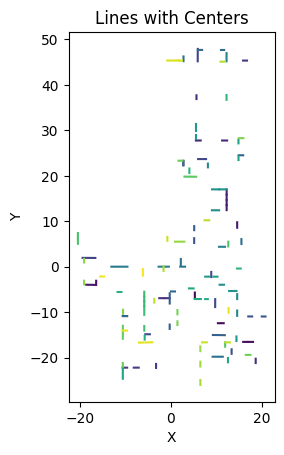

In [40]:
lines = []

for n in potential_doors:
    lines.append([n.startpoint, n.endpoint, n.normal])
print(len(lines))
# plot_lines(lines)
clustered_ids = cluster_lines(lines) 
# plot_clustered_lines_separately(lines, clustered_ids)
all_clusters_indices = retrieve_all_clusters_indices(clustered_ids)
clustered_lines = []

for cluster_indices in all_clusters_indices:
    openings = []
    for i in cluster_indices:
        openings.append(potential_doors[i])
    on = merge_objects(openings)
    clustered_lines.append(on)
    
lines = []
for n in clustered_lines:
    lines.append([n.startpoint, n.endpoint])
    
print(len(lines))

plot_lines(lines, show_centers=False)

In [41]:
def calculate_percentage_black_pixels(image):
    # Check if the image is a color image (3 channels) or a grayscale image (1 channel)
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Convert the color image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        # Image is already grayscale
        grayscale_image = image
    else:
        # Handle other cases or raise an error
        raise ValueError("Unsupported image format. Expected color (3 channels) or grayscale (1 channel).")

    # # Convert the image to grayscale
    # grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Count black pixels
    black_pixel_count = cv2.countNonZero(grayscale_image)

    # Calculate total number of pixels
    total_pixels = grayscale_image.shape[0] * grayscale_image.shape[1]

    # Calculate percentage of black pixels
    percentage_black_pixels = (black_pixel_count / total_pixels) * 100

    return percentage_black_pixels

In [42]:
lines = []

for n in clustered_lines:
    lines.append([n.startpoint, n.endpoint, n.normal])
    
clustered_ids = cluster_lines(lines, distance_threshold=1.2, equal_normals = False)
all_clusters_indices = retrieve_all_clusters_indices(clustered_ids)

openings = []
for cluster in all_clusters_indices:
    if len(cluster) > 1:
        l = [clustered_lines[i] for i in cluster]
        
        # Plotting the images
        # fig, axes = plt.subplots(1, len(l))            
        
        lines = []
        i = 0
        for j, n in enumerate(l):
            lines.append([n.startpoint, n.endpoint, n.normal])
            # axes[i].imshow(Image.fromarray(n.image[0][0]))
            # axes[i].axis('off')
            i+=1
            if calculate_percentage_black_pixels(n.image[0][0]) < 50:
                openings.append(n)
                for jj, n2 in enumerate(l): 
                    if not jj == j:
                        if np.array_equal(n.normal, n2.normal):
                            openings.append(n2)
                
        # plot_lines(lines)
    else:
        openings.append(clustered_lines[cluster[0]])

90


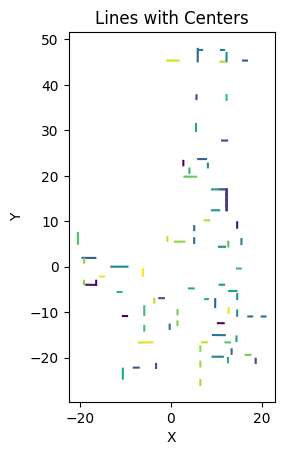

In [43]:
lines =[]
for n in openings:
    # n.center = compute_center(n.startpoint, n.endpoint)
    lines.append([n.startpoint, n.endpoint, n.normal])
    
    
print(len(lines))
plot_lines(lines, show_centers=False)

In [44]:
# Compare ground truth nodes with computed nodes
# print(len(groundtruthNodes))
for ground_truth_node in groundtruthNodes:
    min_distance = float('inf')
    best_node = None
    for computed_node in openings:
        # print(ground_truth_node.center)
        # print(compute_center(computed_node.startpoint, computed_node.endpoint))
        # print(computed_node.center)
        distance = calculate_distance(ground_truth_node.center, computed_node.center)
        
        if distance < min_distance:
            min_distance = distance
            best_node = computed_node
    print('Found match on: %s'% (min_distance))
    print('WIDTH = GT: %s, Computed: %s' %(ground_truth_node.width, best_node.width))
    print('DEPTH = GT: %s, Computed: %s' %(ground_truth_node.depth, best_node.depth))
    print('HEIGHT = GT: %s, Computed: %s' %(ground_truth_node.height, best_node.height))

Found match on: 0.06525498068703132
WIDTH = GT: 0.9652000000000004, Computed: 1.0110086698655318
DEPTH = GT: 0.1651000000000018, Computed: 0.24440071606179292
HEIGHT = GT: 2.2097999999999995, Computed: 2.175
Found match on: 0.0693835301145954
WIDTH = GT: 1.0668000000000004, Computed: 0.9804362075158647
DEPTH = GT: 0.15240000000000198, Computed: 0.21450321890818852
HEIGHT = GT: 2.2097999999999995, Computed: 2.04
Found match on: 0.052135259785165054
WIDTH = GT: 1.0668000000000004, Computed: 1.0304584630013645
DEPTH = GT: 0.15240000000000198, Computed: 0.21450321890818852
HEIGHT = GT: 2.2097999999999995, Computed: 1.8900000000000001
Found match on: 3.7102845198049303
WIDTH = GT: 1.0668000000000004, Computed: 1.030732501449837
DEPTH = GT: 0.177800000000002, Computed: 0.23362131375466583
HEIGHT = GT: 2.2097999999999995, Computed: 2.15
Found match on: 3.7150109901631594
WIDTH = GT: 1.0668000000000004, Computed: 1.0607538364435285
DEPTH = GT: 0.177800000000002, Computed: 0.23362131375466583
H

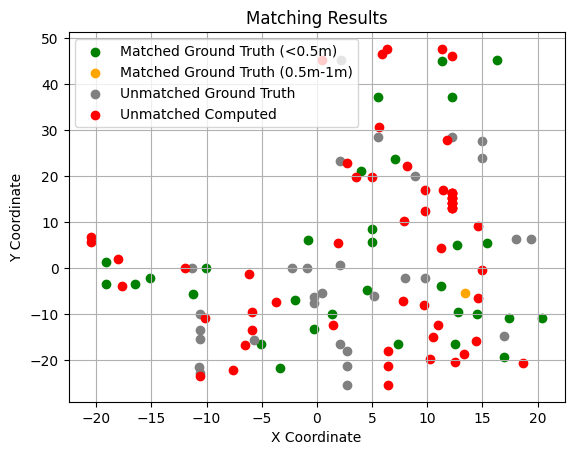

In [45]:
import matplotlib.pyplot as plt

# Lists to store coordinates of matched, unmatched ground truth nodes, and unmatched computed nodes
matched_gt_x = []
matched_gt_y = []
matched_near_gt_x = []
matched_near_gt_y = []
unmatched_gt_x = []
unmatched_gt_y = []
unmatched_calc_x = []
unmatched_calc_y = []

# Iterate through each ground truth node
for ground_truth_node in groundtruthNodes:
    min_distance = float('inf')
    best_node = None
    
    # Iterate through each computed node
    for computed_node in openings:
        distance = calculate_distance(ground_truth_node.center, computed_node.center)
        
        if distance < min_distance:
            min_distance = distance
            best_node = computed_node
    
    # Check if a match was found
    if min_distance < 0.25:
        matched_gt_x.append(ground_truth_node.center[0])
        matched_gt_y.append(ground_truth_node.center[1])
    elif min_distance < 0.5:  # Check if the matched node is less than 1m
        matched_near_gt_x.append(ground_truth_node.center[0])
        matched_near_gt_y.append(ground_truth_node.center[1])
    else:
        unmatched_gt_x.append(ground_truth_node.center[0])
        unmatched_gt_y.append(ground_truth_node.center[1])

# Iterate through each computed node and check if it was matched
for computed_node in openings:
    matched = False
    for ground_truth_node in groundtruthNodes:
        distance = calculate_distance(ground_truth_node.center, computed_node.center)
        if distance < 0.5:
            matched = True
            break
    if not matched:
        unmatched_calc_x.append(computed_node.center[0])
        unmatched_calc_y.append(computed_node.center[1])

# Plot matched ground truth nodes in green
plt.scatter(matched_gt_x, matched_gt_y, color='green', label='Matched Ground Truth (<0.5m)')

# Plot matched ground truth nodes in orange (between 0.5m and 1m)
plt.scatter(matched_near_gt_x, matched_near_gt_y, color='orange', label='Matched Ground Truth (0.5m-1m)')

# Plot unmatched ground truth nodes in gray
plt.scatter(unmatched_gt_x, unmatched_gt_y, color='gray', label='Unmatched Ground Truth')

# Plot unmatched computed nodes in red
plt.scatter(unmatched_calc_x, unmatched_calc_y, color='red', label='Unmatched Computed')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Matching Results')
plt.legend()
plt.grid(True)
plt.show()
